In [1]:
!pip install datasets transformers torch nlpaug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 5.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 48.4 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=7dd876cc2f04f275541e82ab3aa24501979510a56053846056672c69e28fb823
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8d/df/71/846b2aa0fabaac2af23fbc5214eeaa55f0616e9d1a05187d72
Successfu

# Download Data & Prepare

The script `wrangling_segment.py` by default will use files downloaded to prepare the datasets for predicting UNSPSC market Segment. If the --download flag is passed, the program first hits the web sources for this data and downloads them prior to creating prepared data.

In [2]:
!python wrangling_segment.py --download

downloading https://data.ok.gov/dataset/18a622a6-32d1-48f6-842a-8232bc4ca06c/resource/b92ad3ac-b0f5-4c62-9bd0-eac023cfd083/download/data-unspsc-codes.csv to ./data/codes/data-unspsc-codes.csv
    done
downloading https://data.ca.gov/dataset/ae343670-f827-4bc8-9d44-2af937d60190/resource/bb82edc5-9c78-44e2-8947-68ece26197c5/download/purchase-order-data-2012-2015-.csv to ./data/california/purchase-order-data-2012-2015-.csv
    done
downloading https://data.gov.au/data/dataset/5c7fa69b-b0e9-4553-b8df-2a022dd2e982/resource/561a549b-5a65-450e-86cf-81d392d8fef3/download/20142015fy.csv to ./data/australia/20142015fy.csv
    done
downloading https://data.gov.au/data/dataset/5c7fa69b-b0e9-4553-b8df-2a022dd2e982/resource/21212500-169f-4745-86b3-6ac1c1174151/download/2016-2017-australian-government-contract-data.csv to ./data/australia/2016-2017-australian-government-contract-data.csv
    done
downloading https://data.gov.au/data/dataset/5c7fa69b-b0e9-4553-b8df-2a022dd2e982/resource/bc2097b7-8116-

# Conduct Data Augmentation

Class imbalance is a significant problem in this task. The largest segment has several thousand langauge samples, while the smallest has less than 100. As a result, data augmentation using randomised synonym replacement has been used to try to augment the training set.

The script `data_augmentation.py` is able to implement this and includes options for the augmentation routine. In particular, it is possible to perform augmentation to a certain level while undersampling the larger segments to ensure that the classification problem is perfectly balanced. Excess samples are redistributed to the test set for later use in validation. It is also possible to set the number to increase the under-represented classes to. 

The default behaviour lifts the number of samples in each of the under-represented classes to 1000 records, while leaving the over-represented classes unchanged.

Defaults are sufficient for our current purposes.

In [ ]:
!mkdir prepared_data/rebalanced

In [3]:
!python data_augmentation.py

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Upload Prepared Files to S3

In [4]:
#upload again.
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = 'unspsc-data-private'
prefix = 'segment_training'

data_input = sagemaker_session.upload_data(path = './prepared_data/rebalanced/', bucket= bucket, key_prefix=prefix)

# RNN Baseline Model

In [2]:
#for restart --

data_input = 's3://unspsc-data/segment_training'

In [3]:
import sagemaker
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()


We need to pass with our entry point script a requirements.txt file for sagemaker to be able to install torchtext.

Information on how to do this obtained from:

https://github.com/awslabs/sagemaker-privacy-for-nlp/blob/master/source/sagemaker/2.Model_Training.ipynb

I install pip-tools and use the pip-compile feature to extract all libraries to support what is in requirements.in which are all of the modules imported by train_rnn.py

In [4]:
!pip install pip-tools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 KB 12.5 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip-compile ./rnn_baseline/requirements.in > ./rnn_baseline/requirements.txt

#
# This file is autogenerated by pip-compile with python 3.8
# To update, run:
#
#    pip-compile ./rnn_baseline/requirements.in
#
--extra-index-url https://pip.repos.neuron.amazonaws.com

attrs==21.4.0
    # via sagemaker
awscli==1.25.76
    # via -r ./rnn_baseline/requirements.in
boto3==1.24.75
    # via
    #   -r ./rnn_baseline/requirements.in
    #   sagemaker
botocore==1.27.75
    # via
    #   awscli
    #   boto3
    #   s3transfer
certifi==2022.9.14
    # via requests
charset-normalizer==2.1.1
    # via requests
colorama==0.4.4
    # via awscli
dill==0.3.5.1
    # via
    #   multiprocess
    #   pathos
docutils==0.16
    # via awscli
google-pasta==0.2.0
    # via sagemaker
idna==3.4
    # via requests
importlib-metadata==4.12.0
    # via sagemaker
jmespath==1.0.1
    # via
    #   boto3
    #   botocore
joblib==1.2.0
    # via scikit-learn
multiprocess==0.70.13
    # via pathos
numpy==1.23.3
    # via
    #   pandas
    #   sagemaker
    #   scikit-learn
    #   scipy
    # 

In [6]:
estimator = PyTorch(entry_point='train_rnn.py',
                    source_dir = './rnn_baseline/',
                    instance_count = 1,
                    instance_type = 'ml.g4dn.xlarge',
                    framework_version = '1.10',
                    py_version='py38',
                    role = role)

In [7]:
estimator.fit({'training':data_input}, wait = True)

2022-09-18 03:39:34 Starting - Starting the training job...
2022-09-18 03:39:57 Starting - Preparing the instances for trainingProfilerReport-1663472373: InProgress
.........
2022-09-18 03:41:33 Downloading - Downloading input data
2022-09-18 03:41:33 Training - Downloading the training image.....................
2022-09-18 03:45:04 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-18 03:45:07,547 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-18 03:45:07,578 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-18 03:45:07,585 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-18 03:45:08,070 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requir

In [8]:
rnn_accuracy = 0.7036172602181306
rnn_bal_acc = 0.5161409937757544

# Distilbert HyperParameter Tuning

In [3]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [17]:
data_input

's3://unspsc-data/segment_training'

In [4]:
from sagemaker.huggingface import HuggingFace

role = sagemaker.get_execution_role()

In [4]:
huggingface_estimator = HuggingFace(entry_point='unspsc_distilbert_sagemaker_hpo.py',
                                    instance_count=1,
                                    instance_type="ml.g4dn.xlarge",
                                    transformers_version='4.12',
                                    pytorch_version='1.9',
                                    py_version='py38',
                                    role=role)

hyperparameter_ranges = {
    "lr": ContinuousParameter(1e-5, 1e-3),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(1, 2),
    'eps': ContinuousParameter(1e-8, 1e-7)
}

objective_metric_name = "Balanced Accuracy Final:"
objective_type = "Maximize"
metric_definitions = [{"Name": "Balanced Accuracy Final:", "Regex": "Balanced Accuracy Final: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    huggingface_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)



In [ ]:
tuner.fit({"training": data_input})

# Optimal Parameters

In [5]:
tuner = tuner.attach(tuning_job_name='huggingface-pytorch--220910-1109')

In [6]:
# get the best hyperparameter outcome.
tuner.describe()['BestTrainingJob']['FinalHyperParameterTuningJobObjectiveMetric']['Value']

0.6992034316062927

In [7]:
best_estimator= tuner.best_estimator()


2022-09-10 18:53:30 Starting - Found matching resource for reuse
2022-09-10 18:53:30 Downloading - Downloading input data
2022-09-10 18:53:30 Training - Training image download completed. Training in progress.
2022-09-10 18:53:30 Uploading - Uploading generated training model
2022-09-10 18:53:30 Completed - Resource released due to keep alive period expiry


In [8]:
hyperparameters = best_estimator.hyperparameters()

print(hyperparameters)

{'_tuning_objective_metric': '"Balanced Accuracy Final:"', 'batch-size': '"128"', 'epochs': '2', 'eps': '3.848853581472183e-08', 'lr': '9.300726878687543e-05', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"HuggingFace"', 'sagemaker_estimator_module': '"sagemaker.huggingface.estimator"', 'sagemaker_job_name': '"huggingface-pytorch-training-2022-09-10-11-09-13-895"', 'sagemaker_program': '"unspsc_distilbert_sagemaker_hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-556976497373/huggingface-pytorch-training-2022-09-10-11-09-13-895/source/sourcedir.tar.gz"'}


In [9]:
actual_hyperparameter_names = ['batch-size', 'epochs', 'eps', 'lr']

hyperparameters_for_profiling = {key:value for key, value in hyperparameters.items() if key in actual_hyperparameter_names}

In [10]:
hyperparameters_for_profiling

{'batch-size': '"128"',
 'epochs': '2',
 'eps': '3.848853581472183e-08',
 'lr': '9.300726878687543e-05'}

In [8]:
#for restart

hyperparameters_for_profiling = {'batch-size': '"128"',
                                 'epochs': '2',
                                 'eps': '3.848853581472183e-08',
                                 'lr': '9.300726878687543e-05'}


# Profiling

In [6]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [Rule.sagemaker(rule_configs.vanishing_gradient(), collections_to_save=[CollectionConfig(name = 'gradients',
                                                                                                        parameters = {
                                                                                                            'train.save_interval': '50',
                                                                                                            'eval.save_interval': '5'
                                                                                                        }
                                                                                                        )]),
         Rule.sagemaker(rule_configs.overfit()),
         Rule.sagemaker(rule_configs.overtraining()),
         Rule.sagemaker(rule_configs.poor_weight_initialization(), collections_to_save=[CollectionConfig(name = 'weights',
                                                                                                        parameters = {
                                                                                                            'train.save_interval': '50',
                                                                                                            'eval.save_interval': '5'
                                                                                                        }
                                                                                                        )]),
         Rule.sagemaker(rule_configs.loss_not_decreasing(), collections_to_save=[CollectionConfig(name="losses",
                                                                                                  parameters={
                                                                                                      "train.save_interval": "50",
                                                                                                      "eval.save_interval": "5"
                                                                                                  }
                                                                                                 )]),
         ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
         ProfilerRule.sagemaker(rule_configs.ProfilerReport())
        ]




profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                 framework_profile_params=FrameworkProfile(num_steps=10))

debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval": "50",
                                                      "eval.save_interval": "5"
                                                     })

In [9]:
huggingface_estimator_profile = HuggingFace(entry_point='train_distilbert.py',
                                    instance_count=1,
                                    instance_type="ml.g4dn.xlarge",
                                    hyperparameters=hyperparameters_for_profiling,
                                    transformers_version='4.12',
                                    pytorch_version='1.9',
                                    py_version='py38',
                                    role=role, 
                                    profiler_config = profiler_config,
                                    debugger_hook_config= debugger_config,
                                    rules = rules)

In [ ]:
huggingface_estimator_profile.fit({'training': data_input}, wait = True)

2022-09-12 10:18:39 Starting - Starting the training job...
2022-09-12 10:19:07 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-09-12 10:20:08 Downloading - Downloading input data...
2022-09-12 10:20:37 Training - Downloading the training image..........................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-12 10:24:46,987 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-12 10:24:47,018 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-12 10:24:47,025 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-12 10:24:47,593 sagemaker-training-toolkit INFO     Invoking user scrip

# Profiling Information

In [13]:
huggingface_estimator_profile = huggingface_estimator_profile.attach('huggingface-pytorch-training-2022-09-12-10-18-38-954')


2022-09-12 14:34:59 Starting - Preparing the instances for training
2022-09-12 14:34:59 Downloading - Downloading input data
2022-09-12 14:34:59 Training - Training image download completed. Training in progress.
2022-09-12 14:34:59 Uploading - Uploading generated training model
2022-09-12 14:34:59 Completed - Training job completed


In [2]:
debug_output_s3_path = 's3://sagemaker-us-east-1-556976497373/huggingface-pytorch-training-2022-09-12-10-18-38-954/debug-output/'

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(debug_output_s3_path)

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()



[2022-09-18 03:00:14.642 ip-172-16-83-215.ec2.internal:17800 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-18 03:00:15.271 ip-172-16-83-215.ec2.internal:17800 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-556976497373/huggingface-pytorch-training-2022-09-12-10-18-38-954/debug-output/
[2022-09-18 03:00:16.126 ip-172-16-83-215.ec2.internal:17800 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 24207 more expected)', IncompleteRead(0 bytes read, 24207 more expected)) while reading s3://sagemaker-us-east-1-556976497373/huggingface-pytorch-training-2022-09-12-10-18-38-954/debug-output/index/000000004/000000004305_worker_0.json . Will retry now


Matplotlib is building the font cache; this may take a moment.


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


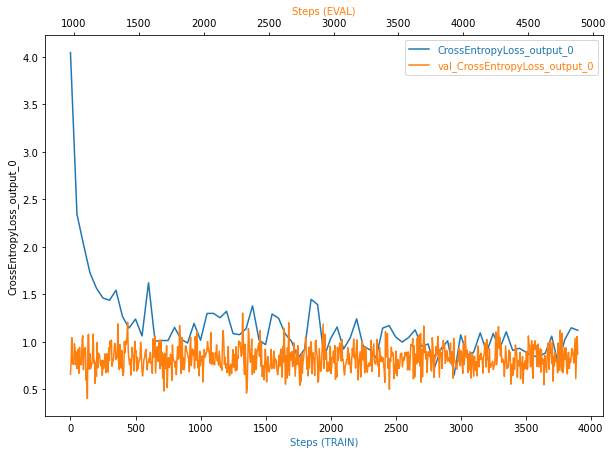

In [4]:

plot_tensor(trial, 'CrossEntropyLoss_output_0')

In [ ]:
from smdebug.profiler.system_metrics_reader import S3SystemMetricsReader
#from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

system_metrics_reader = S3SystemMetricsReader(path)


system_metrics_reader.refresh_event_file_list()
#metrics_histogram = MetricsHistogram(system_metrics_reader)

# Deploy to Endpoint

# References

[huggingface tutorial notebook](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb)


[huggingface sagemaker tutorial](https://github.com/huggingface/notebooks/blob/main/sagemaker/01_getting_started_pytorch/sagemaker-notebook.ipynb)

[data augmentation from netune ai](https://neptune.ai/blog/data-augmentation-nlp)

[textual augmentation example code](https://github.com/makcedward/nlpaug/blob/23800cbb9632c7fc8c4a88d46f9c4ecf68a96299/example/textual_augmenter.ipynb)